In [1]:
import os
# Changing the working directory
os.chdir('..')
os.getcwd()

'/home/javiermunoz/TFM_DSBD'

In [2]:
from config import DATA_PATH, VIDEOS_PATH
import pandas as pd
from sklearn.model_selection import train_test_split
from config import SPLITS
from numpy.random import default_rng
import shutil

## 0. Data Organization

In [3]:
# Load the labels data
labels = pd.read_csv('./data/labels.csv')
labels

,gloss_id,gloss,hand
0,1,Opaque,R
1,2,Red,R
2,3,Green,R
3,4,Yellow,R
4,5,Bright,R
...,...,...,...
59,60,Copy,B
60,61,Run,B
61,62,Realize,R
62,63,Give,B


In [4]:
list_of_videos = os.listdir(VIDEOS_PATH)
print(f"The number of videos in the dataset is: {len(list_of_videos)}")

The number of videos in the dataset is: 3200


In [5]:
# Create a metadata dictionary
metadata_dict = {
    "video_id": [],
    "gloss_id": [],
    "interpreter_id": [],
    "take_id": []
}

for video_id in list_of_videos:
    str_splits = video_id.split("_")
    gloss_id, interpreter_id, take_id = int(str_splits[0]), str_splits[1], str_splits[2].split(".")[0]
    metadata_dict["gloss_id"].append(gloss_id)
    metadata_dict["interpreter_id"].append(interpreter_id)
    metadata_dict["take_id"].append(take_id)
    metadata_dict["video_id"].append(video_id)

metadata_df = pd.DataFrame(metadata_dict)
metadata_df

,video_id,gloss_id,interpreter_id,take_id
0,018_010_005.mp4,18,010,005
1,014_010_004.mp4,14,010,004
2,042_004_004.mp4,42,004,004
3,041_003_005.mp4,41,003,005
4,037_006_005.mp4,37,006,005
...,...,...,...,...
3195,023_001_001.mp4,23,001,001
3196,048_010_005.mp4,48,010,005
3197,038_008_005.mp4,38,008,005
3198,003_002_001.mp4,3,002,001


In [6]:
# Join both dictionaries
full_metadata_df = metadata_df.merge(labels, on='gloss_id')
full_metadata_df

,video_id,gloss_id,interpreter_id,take_id,gloss,hand
0,018_010_005.mp4,18,010,005,Skimmer,R
1,018_010_003.mp4,18,010,003,Skimmer,R
2,018_008_003.mp4,18,008,003,Skimmer,R
3,018_006_005.mp4,18,006,005,Skimmer,R
4,018_007_004.mp4,18,007,004,Skimmer,R
...,...,...,...,...,...,...
3195,034_009_002.mp4,34,009,002,Map,B
3196,034_008_001.mp4,34,008,001,Map,B
3197,034_009_005.mp4,34,009,005,Map,B
3198,034_004_003.mp4,34,004,003,Map,B


In [7]:
# Check that there are no nulls
full_metadata_df.isnull().any(), full_metadata_df.isna().any()

(video_id          False
 gloss_id          False
 interpreter_id    False
 take_id           False
 gloss             False
 hand              False
 dtype: bool,
 video_id          False
 gloss_id          False
 interpreter_id    False
 take_id           False
 gloss             False
 hand              False
 dtype: bool)

In [8]:
full_metadata_df[full_metadata_df.isnull().any(axis=1)]

,video_id,gloss_id,interpreter_id,take_id,gloss,hand


In [9]:
metadata_4_train, metadata_4_test = train_test_split(full_metadata_df, test_size=0.2, shuffle=True)
metadata_4_val, metadata_4_test = train_test_split(metadata_4_test, test_size=0.4, shuffle=True)

In [10]:
metadata_4_train["sp"] = 'train'
metadata_4_val["sp"] = 'val'
metadata_4_test["sp"] = 'test'
full_metadata_df = pd.concat([metadata_4_train, metadata_4_val, metadata_4_test])
full_metadata_df.reset_index(inplace=True)
full_metadata_df.drop(columns=['index'], inplace=True)
full_metadata_df

,video_id,gloss_id,interpreter_id,take_id,gloss,hand,sp
0,022_003_003.mp4,22,003,003,Water,R,train
1,055_007_005.mp4,55,007,005,Catch,B,train
2,060_002_003.mp4,60,002,003,Copy,B,train
3,054_008_002.mp4,54,008,002,To land,B,train
4,020_008_003.mp4,20,008,003,Sweet milk,R,train
...,...,...,...,...,...,...,...
3195,052_007_003.mp4,52,007,003,Shut down,R,test
3196,011_002_004.mp4,11,002,004,Son,R,test
3197,014_002_001.mp4,14,002,001,Drawer,R,test
3198,001_010_001.mp4,1,010,001,Opaque,R,test


## 1.Data Analysis

In [11]:
# define a function to get number of frames per video
import cv2
def get_n_frames_video(video_path):

    cap = cv2.VideoCapture(video_path)
    count = 0

    try:
        count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    except:
        ret = True
        while ret:
            ret = cap.read()
            count += 1

    cap.release()

    return count

In [12]:
# we now apply this function to the dataset, to get the frames per video and append it to the dataframe columns

video_frames = []
for index, row in full_metadata_df.iterrows():
    vid_path = os.path.join(VIDEOS_PATH, row['video_id'])
    video_frames.append(get_n_frames_video(vid_path))

frames_df=pd.DataFrame({"frames":video_frames})

full_metadata_df = pd.concat([full_metadata_df, frames_df], axis=1)
full_metadata_df

,video_id,gloss_id,interpreter_id,take_id,gloss,hand,sp,frames
0,022_003_003.mp4,22,003,003,Water,R,train,76
1,055_007_005.mp4,55,007,005,Catch,B,train,50
2,060_002_003.mp4,60,002,003,Copy,B,train,93
3,054_008_002.mp4,54,008,002,To land,B,train,112
4,020_008_003.mp4,20,008,003,Sweet milk,R,train,68
...,...,...,...,...,...,...,...,...
3195,052_007_003.mp4,52,007,003,Shut down,R,test,77
3196,011_002_004.mp4,11,002,004,Son,R,test,63
3197,014_002_001.mp4,14,002,001,Drawer,R,test,42
3198,001_010_001.mp4,1,010,001,Opaque,R,test,83


In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("Frame length information:\n")
print(f"\tMinimum frames per video: {np.min(full_metadata_df['frames'])}")
print(f"\tMaximum frames per video: {np.max(full_metadata_df['frames'])}")
print(f"\tAverage frames per video: {np.mean(full_metadata_df['frames'])}")
print(f"\tStandard deviation frames per video: {np.std(full_metadata_df['frames'])}")

Frame length information:

	Minimum frames per video: 14
	Maximum frames per video: 201
	Average frames per video: 82.7596875
	Standard deviation frames per video: 27.576474346847586


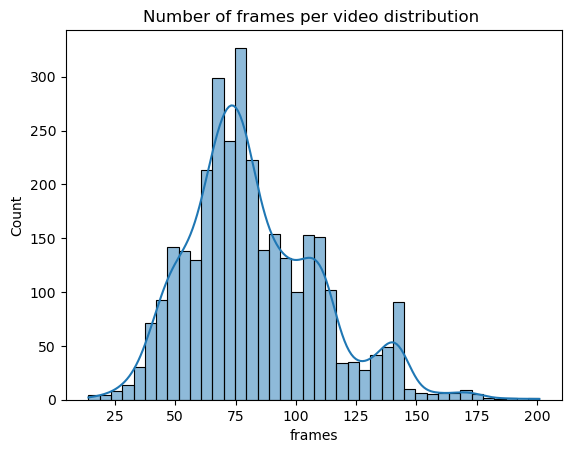

In [15]:
sns.histplot(full_metadata_df['frames'], kde=True)
plt.title("Number of frames per video distribution ")
plt.show()

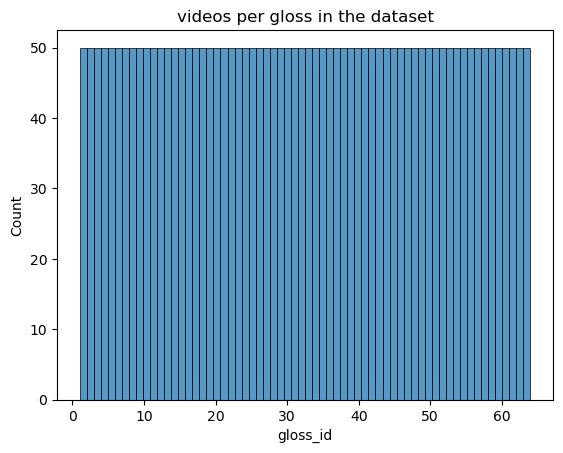

In [17]:
sns.histplot(full_metadata_df['gloss_id'], bins=64)
plt.title("videos per gloss in the dataset")
plt.show()

<Axes: xlabel='frames', ylabel='gloss_id'>

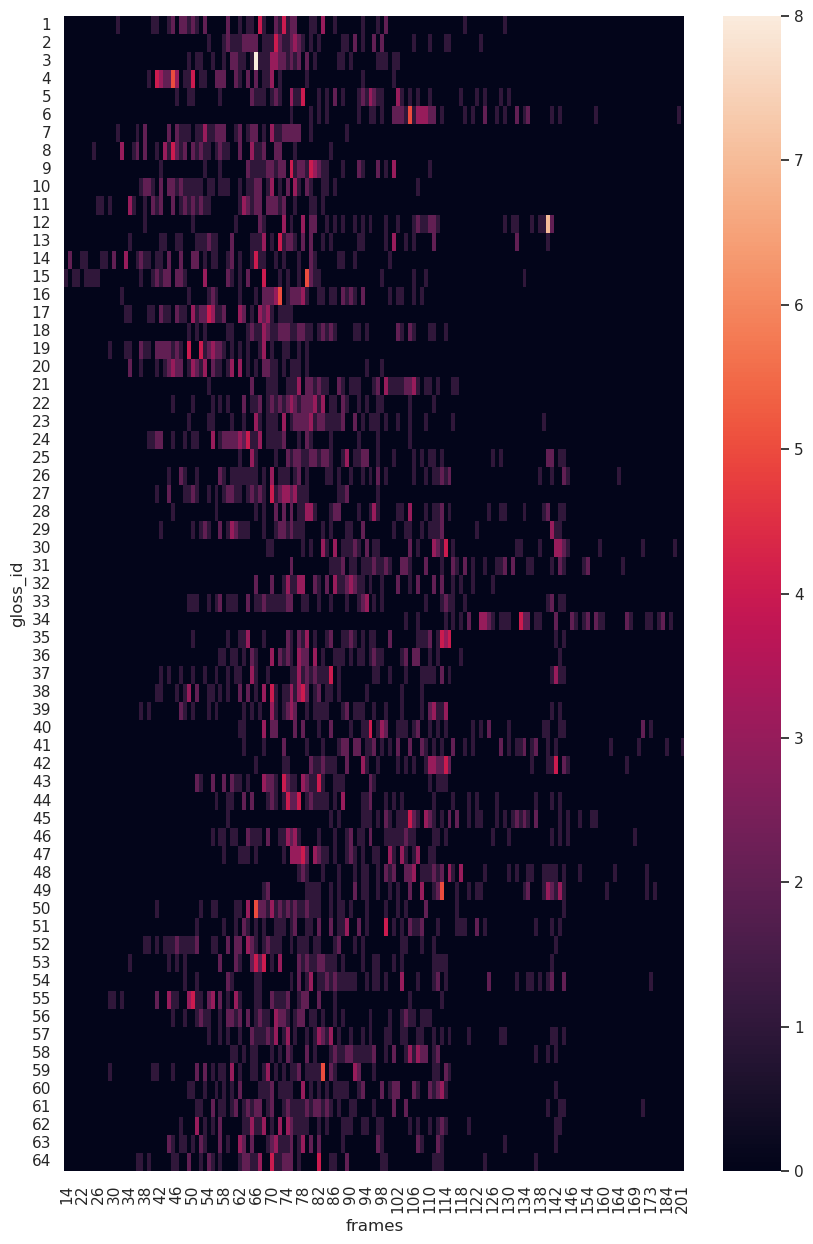

In [21]:
data = pd.crosstab(full_metadata_df['gloss_id'], full_metadata_df['frames'])
sns.set(rc={"figure.figsize":(10, 15)})
if_cmap = sns.color_palette("rocket", as_cmap=True)
sns.heatmap(data, cmap=if_cmap)

## 2. Creating Subsets

In [11]:
# we take a subset of classes from the whole dataset
rng = default_rng()
subset_size = 10
subset_labels = rng.choice(len(labels), size=subset_size, replace=False)

subset_metadata_df = full_metadata_df[full_metadata_df['gloss_id'].isin(subset_labels + 1)]
subset_metadata_df.reset_index()
subset_metadata_df

,video_id,gloss_id,interpreter_id,take_id,gloss,hand,sp
2647,059_007_002.mp4,59,007,002,Buy,R,train
2697,045_005_003.mp4,45,005,003,Barbecue,B,train
2910,054_001_002.mp4,54,001,002,To land,B,train
1927,021_010_001.mp4,21,010,001,Milk,R,train
838,062_008_005.mp4,62,008,005,Realize,R,train
...,...,...,...,...,...,...,...
771,020_009_002.mp4,20,009,002,Sweet milk,R,test
2670,045_004_003.mp4,45,004,003,Barbecue,B,test
1916,021_009_002.mp4,21,009,002,Milk,R,test
3039,030_008_004.mp4,30,008,004,Birthday,R,test


In [12]:
CREATE_SUBSET = True
erase_original = False
subset = f"subset_{subset_size}_lsa_64"

In [13]:
if CREATE_SUBSET:
    # iterate through rows of the dataset
    for index, row in subset_metadata_df.iterrows():
        source = os.path.join(VIDEOS_PATH, row['video_id'])
        destination = os.path.join(DATA_PATH, subset, row['sp'], row['gloss'])

        # create the dataset structure /data/videos/<train|test|val>/gloss
        if not os.path.exists(destination): 
            os.makedirs(destination)

        # and now, we copy from /data/videos to /data/subset_{subset_size}_lsa_64/<train|test|val>/gloss
        if os.path.exists(source):
            shutil.copy(source, destination)

        if erase_original:
            os.remove(source)

## 2. Data Augmentation

In [15]:
import random
import numpy as np
import vidaug.augmentors as va 
from PIL import Image
from tqdm import tqdm
from augment_dataset import video_loader, data_transformer, from_PIL_to_opencv
MAX_AUG = 1
DATA_AUG = False
random.seed()

In [16]:
to_aument = random.randint(0, MAX_AUG)
subset_path = os.path.join(DATA_PATH, subset)

In [17]:
if DATA_AUG:
    for sp in SPLITS:
        for gloss in tqdm(os.listdir(os.path.join(subset_path, sp))):
            for video_name in os.listdir(os.path.join(subset_path, sp, gloss)):
                for i in range(to_aument):
                    video_path = os.path.join(subset_path, sp, gloss, video_name)
                    # get metadata from the video and encoding the output
                    cap = cv2.VideoCapture(video_path)
                    fps = cap.get(cv2.CAP_PROP_FPS)
                    fourCC = cv2.VideoWriter_fourcc("m", "p", "4", "v")
                    # retrieve frames as PIL images
                    frames = video_loader(video_path)
                    # get frame width and height
                    frame_width, frame_height = frames[0].size

                    vid_name = video_name.split(".")[0]
                    aug_vid_name = f"{vid_name}_aug{i}.mp4"
                    aug_frames = data_transformer(frames, frame_height, frame_width, crop_factor=0.2)
                    new_frame_width, new_frame_height = aug_frames[0].size
                    cv2_frames = from_PIL_to_opencv(aug_frames)  
                    path_out = os.path.join(subset_path, sp, gloss, aug_vid_name)
                    out = cv2.VideoWriter(path_out, fourCC, fps, (new_frame_width, new_frame_height))

                    for frame in cv2_frames:
                        out.write(frame)

                    out.release()
                    cap.release()